This code compares the HyMoLAP and LSTM models performance for multi-day ahead streamflow simulation in the Savè sub-catchment.

In [160]:
# Librairies
import pandas as pd
from matplotlib import pylab as plt
from datetime import datetime
import numpy as np
from math import sqrt
from numpy import concatenate

import math

from scipy.stats import norm

import joblib
import matplotlib.dates as mdates
from google.colab import files

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

import json

In [161]:
import random
import os

# Set seed
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If you are using CUDA
np.random.seed(SEED)
random.seed(SEED)

In [162]:
#NSE, RMSE, KGE
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def kge(obs, sim):
    """ Kling-Gupta Efficiency (KGE)"""
    obs, sim = np.array(obs), np.array(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    beta = np.mean(sim) / np.mean(obs)
    gamma = (np.std(sim) / np.mean(sim)) / (np.std(obs) / np.mean(obs))

    return 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)


In [163]:
# Import data
from google.colab import drive
drive.mount('/content/drive')

daily = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/SDE_driven/savè.xlsx')
#('/content/drive/MyDrive/Colab Notebooks/Bonou/calage_biao.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
daily.head()

,debit,pluie,etp,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,0.064,5.6982,3.251933,NaN,1-07-2002 to 31-12-2007,NaN,NaN
1,0.064,8.1508,3.148102,NaN,NaN,NaN,NaN
2,0.064,5.4436,3.164040,NaN,NaN,NaN,NaN
3,0.064,2.4449,3.202455,NaN,NaN,NaN,NaN
4,0.064,4.7224,2.461412,NaN,NaN,NaN,NaN


# HyMoLAP Model

In [165]:
#Calibration data
discharge = daily.iloc[:1280, 0].to_numpy()
prec = daily.iloc[:1280, 1].to_numpy()
pet = daily.iloc[:1280, 2].to_numpy()

In [166]:
#X(t)
def state_basin(MU, LANDA, q):
    n = len(q)
    X = np.zeros(n)
    X[0] = q[0]
    for i in range(1, n):
        if q[i] == 0:
            X[i] = X[i - 1] - (MU / LANDA) * X[i - 1]
        else:
            X[i] = X[i - 1] + (MU / LANDA) * q[i]
    return X

In [167]:
#Estimates of the HyMoLAP
MU = 0.8887674235815656
LAMBDA = 3.995390518490918

Multi-step prediction

VALIDATION

In [168]:
# Validation data
discharge1 = daily.iloc[1280:, 0].to_numpy()
prec1 = daily.iloc[1280:, 1].to_numpy()
pet1 = daily.iloc[1280:, 2].to_numpy()

#Compute the Effective precipitation
prec_eff1 = prec1 - pet1
prec_eff1[prec_eff1 < 0] = 0

#X(t)
X = state_basin(MU, LAMBDA, prec_eff1)

1-day ahead

In [169]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)

    return Q_next

S711 = np.zeros(len(discharge1)) #Vector for stocking the prediction
S711[0] = discharge1[0]

for k in range(0, len(discharge1)-1, 1):
    S711[k + 1] = compute_Q(discharge1[k], X[k] * prec_eff1[k], MU, LAMBDA)


In [170]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S711[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S711[1:]))

print('kge=',kge(discharge1[1:], S711[1:]))


Nash-Sutcliffe Efficiency (NSE): 0.9696001265526427
rmse= 37.14012906105239
kge= 0.9810334953357324


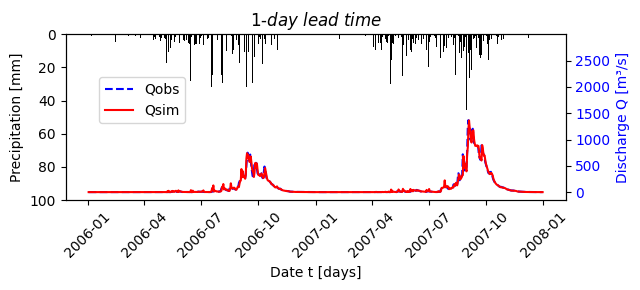

In [171]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2006-01-02')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Set y-axis parameters for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
# ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the prediction
ax2.plot(time, S711[1:], 'red', label='Qsim')

# Set y-axis parameters for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-150, 3000)
ax2.set_yticks(np.arange(0, 3000, 500))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display grid
# plt.grid(True)

# Add a title with LaTeX symbols
plt.title(r'$1$-$day$ $lead$ $time$')

# Use tight_layout to prevent overlaps
plt.tight_layout()

# Show the plot
plt.show()


3-day ahead

In [172]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_values = []
    for i in range(1, 4):
      if i==1:
        Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next
      else:
        Q_next = 2*Q_t-Q_prec
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next

    return tuple(Q_values)

S713 = np.zeros(len(discharge1))
S713[0] = discharge1[0]

for k in range(0, len(discharge1)-2, 3):  #loup
    (S713[k+1], S713[k+2], S713[k+3]) = \
        compute_Q(discharge1[k], X[k]*prec_eff1[k], MU, LAMBDA)


In [173]:
#We check here the last value reached by the loup
S713[-2]==0, S713[-1]==0

(False, False)

In [174]:
#We compute  streamflow for last days that were not considered in the loup
psi = X[-2]*prec_eff1[-2]
S713[-1] = discharge1[-2] +  (- (MU / LAMBDA) * discharge1[-2]**(2 * MU - 1) + (1 / LAMBDA) * psi)

In [175]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S713[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S713[1:]))

print('kge=',kge(discharge1[1:], S713[1:]))


Nash-Sutcliffe Efficiency (NSE): 0.917163817462678
rmse= 61.308057910271756
kge= 0.9533491237205826


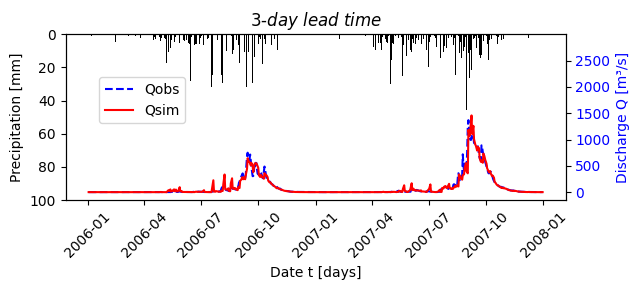

In [176]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2006-01-02')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Set y-axis parameters for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
# ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the prediction
ax2.plot(time, S713[1:], 'red', label='Qsim')

# Set y-axis parameters for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-150, 3000)
ax2.set_yticks(np.arange(0, 3000, 500))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display grid
# plt.grid(True)

# Add a title with LaTeX symbols
plt.title(r'$3$-$day$ $lead$ $time$')

# Use tight_layout to prevent overlaps
plt.tight_layout()

# Show the plot
plt.show()

7-day ahead

In [177]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_values = []
    for i in range(1, 8):
      if i==1:
        Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next
      else:
        Q_next = 2*Q_t-Q_prec
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next

    return tuple(Q_values)

S717 = np.zeros(len(discharge1))
S717[0] = discharge1[0]

for k in range(0, len(discharge1)-6, 7):
    (S717[k+1], S717[k+2], S717[k+3], S717[k+4], S717[k+5], S717[k+6], S717[k+7]) = \
        compute_Q(discharge1[k], X[k]*prec_eff1[k], MU, LAMBDA)


In [178]:
S717[-2]==0, S717[-1]==0

(False, True)

In [179]:
psi = X[-2]*prec_eff1[-2]
S717[-1] = discharge1[-2] +  (- (MU / LAMBDA) * discharge1[-2]**(2 * MU - 1) + (1 / LAMBDA) * psi)

In [180]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S717[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S717[1:]))

print('kge=',kge(discharge1[1:], S717[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.7985413335896814
rmse= 95.60937915838902
kge= 0.9001326905564819


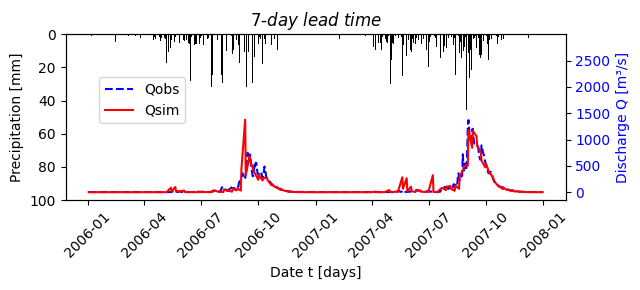

In [181]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2006-01-02')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
# ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the prediction
ax2.plot(time, S717[1:], 'red', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-150, 3000)
ax2.set_yticks(np.arange(0, 3000, 500))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
# plt.grid(True)

# Add a title with LaTeX mathematical symbols
plt.title(r'$7$-$day$ $lead$ $time$')

# Use tight_layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

10-day ahead

In [182]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_values = []
    for i in range(1, 11):
      if i==1:
        Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next
      else:
        Q_next = 2*Q_t-Q_prec
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next

    return tuple(Q_values)

S7110 = np.zeros(len(discharge1))
S7110[0] = discharge1[0]

for k in range(0, len(discharge1)-10, 10):
    (S7110[k+1], S7110[k+2], S7110[k+3], S7110[k+4], S7110[k+5], S7110[k+6], S7110[k+7],
     S7110[k+8], S7110[k+9], S7110[k+10]) = \
        compute_Q(discharge1[k], X[k]*prec_eff1[k], MU, LAMBDA)


In [183]:
S7110[-10]==0, S7110[-9]==0

(False, True)

In [184]:
psi = X[-10]*prec_eff1[-10]
S7110[-9] = discharge1[-10] +  (- (MU / LAMBDA) * discharge1[-10]**(2 * MU - 1) + (1 / LAMBDA) * psi)

for i in range(-8, 0):
    S7110[i] = 2 * S7110[i - 1] - S7110[i - 2]

In [186]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S7110[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S7110[1:]))

print('kge=',kge(discharge1[1:], S7110[1:]))


Nash-Sutcliffe Efficiency (NSE): 0.8197487848265438
rmse= 90.4370986973511
kge= 0.8241133707023724


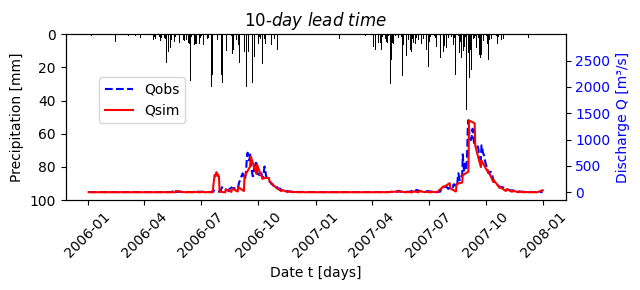

In [187]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2006-01-02')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
# ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the prediction
ax2.plot(time, S7110[1:], 'red', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-150, 3000)
ax2.set_yticks(np.arange(0, 3000, 500))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
# plt.grid(True)

# Add a title with LaTeX mathematical symbols
plt.title(r'$10$-$day$ $lead$ $time$')

# Use tight_layout to prevent overlapping
plt.tight_layout()

# Save the plot as a .jpeg file
plt.savefig("10_hyM_save1.jpeg", format='jpeg', dpi=500)

# Download the file
# files.download("10_hyM_save1.jpeg")

# Display the plot
plt.show()

# ..........................

## LSTM Model

In [188]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=80, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden state and cell state
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # Forward pass through LSTM
        lstm_out, _ = self.lstm(x, (h_0, c_0))

        # Output the last time step's prediction
        out = self.fc(lstm_out[:, -1, :])
        return out

# Model parameters
input_size = 1    # Number of input variables
hidden_size = 105  # Number of hidden units
num_layers = 2     # Number of LSTM layers
output_size = 1    # Number of time steps to predict

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Creating dataset

In [189]:
# Creating the DataFrame for training (calibration)
data_train = pd.DataFrame({
        'discharge': discharge[:-1],
         #'prec': prec[:-1],
         #'pet': pet[:-1],
        'target': discharge[1:]
})

# Creating the DataFrame for validation (test)
data_test = pd.DataFrame({
        'discharge': discharge1[:-1],
         #'prec': prec1[:-1],
         #'pet': pet1[:-1],
        'target': discharge1[1:]
})

# Splitting features and target
train_X, train_y = data_train.iloc[:, :-1].to_numpy(dtype=np.float32), data_train.iloc[:, -1].to_numpy(dtype=np.float32)
test_X, test_y = data_test.iloc[:, :-1].to_numpy(dtype=np.float32), data_test.iloc[:, -1].to_numpy(dtype=np.float32)

# Normalizing features
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_train_X = scaler_X.fit_transform(train_X)
scaled_test_X = scaler_X.transform(test_X)  # Use transform() for test

# Normalizing target
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_train_y = scaler_y.fit_transform(train_y.reshape(-1, 1)).flatten()
scaled_test_y = scaler_y.transform(test_y.reshape(-1, 1)).flatten()


Training

In [190]:
# Converting data to PyTorch tensors
scaled_train_X = torch.tensor(scaled_train_X, dtype=torch.float32).unsqueeze(-1)  # (batch, seq_len, input_size)
scaled_train_y = torch.tensor(scaled_train_y, dtype=torch.float32).unsqueeze(-1)  # (batch, output_size)

# Training parameters
epochs = 250

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Prediction
    y_pred = model(scaled_train_X)

    # Loss computation (correcting y format)
    loss = criterion(y_pred, scaled_train_y)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Display loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


Epoch 0, Loss: 0.0305
Epoch 10, Loss: 0.0274
Epoch 20, Loss: 0.0262
Epoch 30, Loss: 0.0245
Epoch 40, Loss: 0.0213
Epoch 50, Loss: 0.0158
Epoch 60, Loss: 0.0080
Epoch 70, Loss: 0.0017
Epoch 80, Loss: 0.0019
Epoch 90, Loss: 0.0013
Epoch 100, Loss: 0.0013
Epoch 110, Loss: 0.0012
Epoch 120, Loss: 0.0012
Epoch 130, Loss: 0.0012
Epoch 140, Loss: 0.0012
Epoch 150, Loss: 0.0012
Epoch 160, Loss: 0.0012
Epoch 170, Loss: 0.0012
Epoch 180, Loss: 0.0012
Epoch 190, Loss: 0.0012
Epoch 200, Loss: 0.0012
Epoch 210, Loss: 0.0012
Epoch 220, Loss: 0.0012
Epoch 230, Loss: 0.0012
Epoch 240, Loss: 0.0012


# Training Evaluation

In [191]:
# Evaluation mode
model.eval()

LSTMModel(
  (lstm): LSTM(1, 105, num_layers=2, batch_first=True)
  (fc): Linear(in_features=105, out_features=1, bias=True)
)

In [192]:
# Store predictions
predictions = []

# Predict 1-day ahead
for i in range(len(scaled_train_X)):
    input_seq = scaled_train_X[i].reshape(1, 1, -1)  # Ensure (batch=1, seq_length=1, input_size)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)  # Convert to PyTorch tensor

    pred = model(input_seq)  # Prediction
    predictions.append(pred.item())  # Convert to scalar and store

# print("Predictions:", predictions)

<ipython-input-192-8af6e1ee080c>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.float32)  # Convert to PyTorch tensor


In [193]:
# Function to inverse transform the scaled target values back to their original scale
def inverse_transform(y):
  return scaler_y.inverse_transform(y.reshape(-1, 1))

In [194]:
#Invert prevision
predictions_array = np.array(predictions).reshape(-1, 1)
original_predictions = scaler_y.inverse_transform(predictions_array).flatten()

In [195]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge[1:], original_predictions)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge[1:], original_predictions))

print('kge=',kge(discharge[1:], original_predictions))

Nash-Sutcliffe Efficiency (NSE): 0.958523293999513
rmse= 48.01902124348602
kge= 0.9701858808715361


# Validation: 1-day ahead Prediction

In [196]:
# Store the predictions
predictions1 = []

# Predict 1-day ahead for each day in the test set
for i in range(len(scaled_test_X)):
    input_seq = scaled_test_X[i].reshape(1, 1, -1)  # Ensure shape (batch=1, seq_length=1, input_size)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)  # Convert to PyTorch tensor

    pred1 = model(input_seq)  # Prediction
    predictions1.append(pred1.item())  # Convert to scalar and store

In [197]:
#Invert prevision
predictions_array1 = np.array(predictions1).reshape(-1, 1)
original_predictions1 = scaler_y.inverse_transform(predictions_array1).flatten()

In [198]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], original_predictions1)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], original_predictions1))

print('kge=',kge(discharge1[1:], original_predictions1))

Nash-Sutcliffe Efficiency (NSE): 0.9657238855891488
rmse= 39.43694934695758
kge= 0.967472058961915


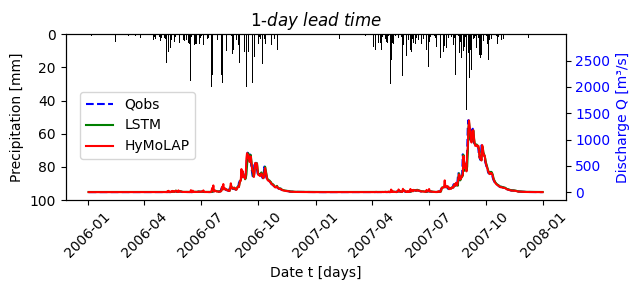

In [199]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2006-01-02')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Set y-axis parameters for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the predictions
ax2.plot(time, original_predictions1, 'g', label='LSTM')
ax2.plot(time, S711[1:], 'r', label='HyMoLAP')

# Set y-axis parameters for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-150, 3000)
ax2.set_yticks(np.arange(0, 3000, 500))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.7))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$1$-$day$ $lead$ $time$')

# Use tight_layout to prevent overlapping
plt.tight_layout()


# Display the plot
plt.show()


# Multi-step Prediction

In [200]:
def multi_step_forecast(model, input_seq, steps):
    """
    Multi-step ahead prediction in a loop
    :param model: Trained model (e.g., LSTM)
    :param input_seq: Initial sequence (torch tensor with shape (1, 1, input_size))
    :param steps: Number of days to predict
    :return: List of multi-step predictions
    """
    model.eval()
    predictions = []
    current_input = input_seq.clone()  # Copy to avoid modifying the original input

    for _ in range(steps):
        pred = model(current_input)  # Model prediction
        predictions.append(pred.item())  # Store the prediction

        # Update the input with the current prediction
        pred = pred.reshape(1, 1, 1)  # Ensure shape (batch=1, seq_length=1, input_size=1)
        current_input = pred  # Replace input with the prediction

    return predictions

3-day ahead

In [201]:
n_step = 3  # Number of time steps to predict

predictions_multi = []  # List to store all predictions

# Iterate over scaled_test_X, taking indices that are multiples of n_step
i = 0
while i < len(scaled_test_X):
    input_seq = scaled_test_X[i].reshape(1, 1, -1)  # Ensure shape (batch=1, seq_length=1, input_size)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)  # Convert to tensor

    pred_steps = multi_step_forecast(model, input_seq, steps=n_step)  # Multi-step prediction
    predictions_multi.extend(pred_steps)  # Add to the global list

    i += n_step  # Move forward by n_step

# Adjust the final size if it exceeds len(scaled_test_X)
if len(predictions_multi) > len(scaled_test_X):
    predictions_multi = predictions_multi[:len(scaled_test_X)]

# Check if the prediction fully covers the test series
print(f"Test series length: {len(scaled_test_X)}")
print(f"Predictions length: {len(predictions_multi)}")
#print(predictions_multi)  # List of predictions

Test series length: 729
Predictions length: 729


In [202]:
#Invert prevision
predictions_multi_array3 = np.array(predictions_multi).reshape(-1, 1)
original_predictions_multi_array3 = scaler_y.inverse_transform(predictions_multi_array3).flatten()

In [203]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge1[1:], original_predictions_multi_array3)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], original_predictions_multi_array3))

print('kge=',kge(discharge1[1:], original_predictions_multi_array3))

Nash-Sutcliffe Efficiency (NSE): 0.9298231824534149
rmse= 56.42926005170493
kge= 0.9325461501837682


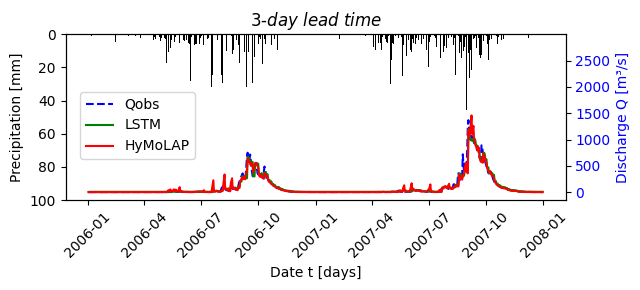

In [204]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2006-01-02')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
# ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the predictions
ax2.plot(time, original_predictions_multi_array3, 'g', label='LSTM')
ax2.plot(time, S713[1:], 'r', label='HyMoLAP')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-150, 3000)
ax2.set_yticks(np.arange(0, 3000, 500))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.7))

# Display the grid
# plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$3$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlapping elements
plt.tight_layout()

# Display the plot
plt.show()


7-day ahead

In [205]:
n_step = 7  # Number of time steps to predict

predictions_multi = []  # List to store all predictions

# Iterate over scaled_test_X, taking indices that are multiples of n_step
i = 0
while i < len(scaled_test_X):
    input_seq = scaled_test_X[i].reshape(1, 1, -1)  # Ensure shape (batch=1, seq_length=1, input_size)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)  # Convert to tensor

    pred_steps = multi_step_forecast(model, input_seq, steps=n_step)  # Multi-step prediction
    predictions_multi.extend(pred_steps)  # Add to the global list

    i += n_step  # Move forward by n_step

# Adjust the final size if it exceeds len(scaled_test_X)
if len(predictions_multi) > len(scaled_test_X):
    predictions_multi = predictions_multi[:len(scaled_test_X)]

# Check if the prediction fully covers the test series
print(f"Test series length: {len(scaled_test_X)}")
print(f"Predictions length: {len(predictions_multi)}")
#print(predictions_multi)  # List of predictions

Test series length: 729
Predictions length: 729


In [206]:
#Invert prevision
predictions_multi_array7 = np.array(predictions_multi).reshape(-1, 1)
original_predictions_multi_array7 = scaler_y.inverse_transform(predictions_multi_array7).flatten()

In [207]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge1[1:], original_predictions_multi_array7)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], original_predictions_multi_array7))

print('kge=',kge(discharge1[1:], original_predictions_multi_array7))

Nash-Sutcliffe Efficiency (NSE): 0.8985235346353435
rmse= 67.85630176066465
kge= 0.9030642703373561


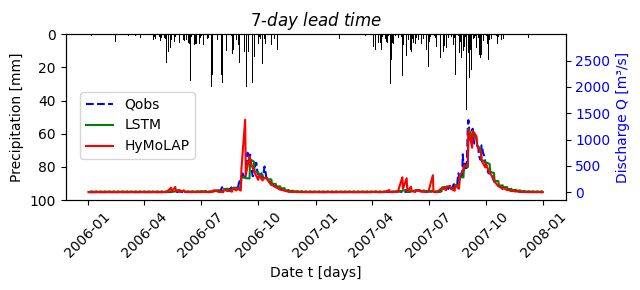

In [208]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2006-01-02')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot the minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot predictions
ax2.plot(time, original_predictions_multi_array7, 'g', label='LSTM')
ax2.plot(time, S717[1:], 'r', label='HyMoLAP')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-150, 3000)
ax2.set_yticks(np.arange(0, 3000, 500))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.7))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX math symbols
plt.title(r'$7$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()


10-day ahead

In [209]:
n_step = 10  # Number of time steps to predict

predictions_multi = []  # List to store all predictions

# Iterate over scaled_test_X, taking indices that are multiples of n_step
i = 0
while i < len(scaled_test_X):
    input_seq = scaled_test_X[i].reshape(1, 1, -1)  # Ensure shape (batch=1, seq_length=1, input_size)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)  # Convert to tensor

    pred_steps = multi_step_forecast(model, input_seq, steps=n_step)  # Multi-step prediction
    predictions_multi.extend(pred_steps)  # Add to the global list

    i += n_step  # Move forward by n_step

# Adjust the final size if it exceeds len(scaled_test_X)
if len(predictions_multi) > len(scaled_test_X):
    predictions_multi = predictions_multi[:len(scaled_test_X)]

# Check if the prediction fully covers the test series
print(f"Test series length: {len(scaled_test_X)}")
print(f"Predictions length: {len(predictions_multi)}")
#print(predictions_multi)  # List of predictions

Test series length: 729
Predictions length: 729


In [210]:
#Invert prevision
predictions_multi_array10 = np.array(predictions_multi).reshape(-1, 1)
original_predictions_multi_array10 = scaler_y.inverse_transform(predictions_multi_array10).flatten()

In [211]:
#Performnance
nse_value = nash_sutcliffe_efficiency(discharge1[1:], original_predictions_multi_array10)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], original_predictions_multi_array10))

print('kge=',kge(discharge1[1:], original_predictions_multi_array10))

Nash-Sutcliffe Efficiency (NSE): 0.8197151880962933
rmse= 90.4455265163804
kge= 0.8591849537752421


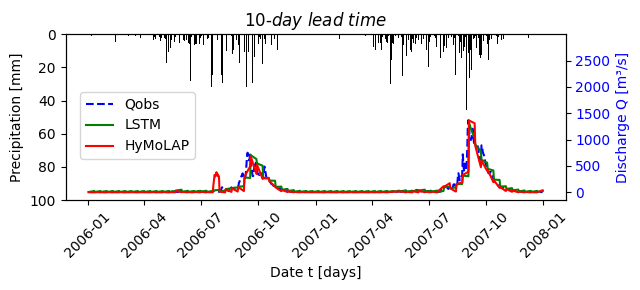

In [212]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2006-01-02')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot the minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the mean of the trajectories
ax2.plot(time, original_predictions_multi_array10, 'g', label='LSTM')
ax2.plot(time, S7110[1:], 'r', label='HyMoLAP')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-150, 3000)
ax2.set_yticks(np.arange(0, 3000, 500))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.7))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX math symbols
plt.title(r'$10$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()
